In [1]:
# Importando Spacy e sua biblioteca em português
import re
import emoji
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
import string
import pt_core_news_lg
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Importando Word2Vec da biblioteca gensim
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.style.use('ggplot')
custom_params = {
    "axes.spines.right": False, 
    "axes.spines.top": False
}
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
# df_tweets = pd.read_csv('data/tweets_erika_modelo_ajustado.csv')
# df_tweets.shape[0]

In [3]:
# Carregando dataset de tweets
file_path = "../data/processed/"
file_name = 'sp_elected_est_fed_dep_tweets'
file_suffix = "analysis"
file_format = 'parquet'

df_tweets = pd.read_parquet(f"{file_path}{file_name}-{file_suffix}.{file_format}")
df_tweets.shape

(125112, 33)

# Pre Processing

In [4]:
# Instanciando Spacy
nlp = spacy.load("pt_core_news_lg")

In [5]:
def remove_emojis_and_urls(text):
    # Regular expression pattern to match emojis
    emoji_pattern = re.compile(
        "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U00002702-\U000027B0"  # Dingbats
            u"\U000024C2-\U0001F251" 
        "]+", 
        flags=re.UNICODE
    )

    # Regular expression pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Remove emojis and URLs from the text
    text_without_emojis_and_urls = emoji_pattern.sub('', text)
    text_without_emojis_and_urls = url_pattern.sub('', text_without_emojis_and_urls)

    return text_without_emojis_and_urls


def clean_tweet(text):
    # Remove emojis and URLs from the text
    text_without_emojis_and_urls = remove_emojis_and_urls(text)

    # Apply spaCy's NLP pipeline to the text without emojis and URLs
    doc = nlp(text_without_emojis_and_urls)

    # Custom list of stopwords to keep
    custom_stopwords = ['não', 'nunca', 'jamais']

    # Regular expression pattern to match special characters (@, (, ), -)
    special_chars_pattern = r'[\(\)\-]'

    # Lemmatize the tokens, remove punctuation, numbers, digits, stopwords, and special characters
    tokens_limpos = [
        re.sub(special_chars_pattern, "", token.lemma_.lower().strip())
        for token in doc
        if not token.is_punct
        and not token.like_num
        and (token.text.lower() in custom_stopwords or not token.is_stop)
    ]

    return tokens_limpos

In [6]:
%%time
# Esta etapa demora um pouco mais
df_tweets['cleaned_content'] = df_tweets['content'].apply(clean_tweet)
df_tweets['cleaned_tokens'] = df_tweets['cleaned_content'].apply(lambda tokens: " ".join(tokens))

CPU times: user 8min 27s, sys: 308 ms, total: 8min 28s
Wall time: 8min 28s


In [13]:
# Salvando arquivos consolidado
output_path = "../data/processed/"
file_name = 'sp_elected_est_fed_dep_tweets'
output_suffix = "cleaned"
file_format = 'parquet'

output_file = f"{output_path}{file_name}-{output_suffix}.{file_format}"
print(output_file)

df_tweets.to_parquet(output_file)

../data/processed/sp_elected_est_fed_dep_tweets-cleaned.parquet


In [7]:
df_off_tweets = df_tweets[df_tweets['class_label'] == True]

In [14]:
df_off_tweets['cleaned_tokens']

200       @anaperugini bolsonaro corrupto  confiscar din...
763          @andreawerner @paizinhovirgula marrentinho lir
835       @andreawerner mulher roubada frente lula fingi...
844       @erikakhilton @andreawerner muito educação  in...
851       @andreawerner vc q candidata bolsonar tebet ta...
                                ...                        
125081                                          ficar pior 
125091                   tiririca bom remédio pra política 
125092                   tiririca bom remédio pra política 
125093                   tiririca bom remédio pra política 
125110    deputado federal  tiririca  deputado  deputado...
Name: cleaned_tokens, Length: 21025, dtype: object

# Word Embeddings

As técnicas do Bag of Words e TF-IDF combinadas com uma boa limpeza de stop words, stemming e lemmatization geralmente geram resultados relevantes em nossas modelagens, mas e se quiséssemos ir um passo além? E se ao invés de contarmos frequências e ocorrências de palavras passássemos a buscar por contextos, informações semânticas e sintáticas nos textos? 

Fazer isso seria quase como ensinar uma máquina a realmente ler e compreender textos, como um humano faz. Para entender melhor sobre isso iremos entrar no mundo das redes neurais e dos word emebeddings! 

Algoritmos de Machine Learning e DeepLearning são especialistas em encontrar padrões em espaços N dimensionais e realizar operações matemáticas com matrizes e vetores. E se houvesse uma forma de transformarmos uma palavra em um vetor? Será que nossa máquina entenderia melhor seu significado?

In [8]:
# Instanciando espaço vetorial
w2v = Word2Vec(
    sentences = df_off_tweets['cleaned_content'],   # Passando listas de tokens tratados
    min_count=5,                                     # Mínimo de ocorrências para considerar a palavra
    vector_size=400,                                 # Dimensão final do embedding 
    window=5,                                        # Janela de contexto 
    seed = 42                                        # Definindo fator Pseudo aleatório
)

# Testando vetores
print(w2v.wv.get_vector('eleições').shape, w2v.wv.get_vector('eleições')[:20])

(400,) [ 0.01907426 -0.0079418  -0.06014191  0.01810997  0.0552105  -0.02725654
 -0.02040097 -0.00439734 -0.11538459  0.02533403  0.04631975  0.07257362
 -0.02799828 -0.02538522 -0.027556   -0.09188174  0.03842433 -0.0385795
  0.05239164 -0.01238585]


In [9]:
# Definindo palavras que serão visualizadas
words = ['lula', 'bolsonaro', 'eleições', 'vergonha', 'crime', 'mentira', 'democracia', 'corrupção']

# Obtendo vetores das palavras
orig_word_vectors = []
for word in words:
    # if word in w2v.wv.key_to_index.keys():
    try:
        orig_word_vectors.append(w2v.wv.get_vector(word))
    except Exception as e:
        print(f'Exceção ao converter palavra "{word}": {e}')

In [57]:
# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
scaled_word_vectors = StandardScaler().fit_transform(orig_word_vectors)

# Instanciando PCA
pca = PCA(n_components=2)
reduced_word_vectors = pca.fit_transform(scaled_word_vectors)

# Criando lista com coordenadas das palavras no espaço vetorial reduzido
word_vectors = {
    'words': words,
    'x': [vec[0] for vec in reduced_word_vectors],
    'y': [vec[1] for vec in reduced_word_vectors],
}

print(word_vectors)
print(f'\n{pca.explained_variance_ratio_=}')

{'words': ['lula', 'bolsonaro', 'eleições', 'vergonha', 'crime', 'mentira', 'democracia', 'corrupção'], 'x': [15.455709109168591, 21.225596762376828, -6.9610918051110025, -20.47464853636673, 14.834953008010059, -14.319799601129738, -6.612402124104056, -3.148316812843955], 'y': [25.532485396256593, -15.047716704319036, -0.35999355101771063, -0.773593442055385, -8.614789460884209, -2.469108210708196, -1.249131687879158, 2.9818476606070936]}

pca.explained_variance_ratio_=array([0.51120037, 0.30307265])


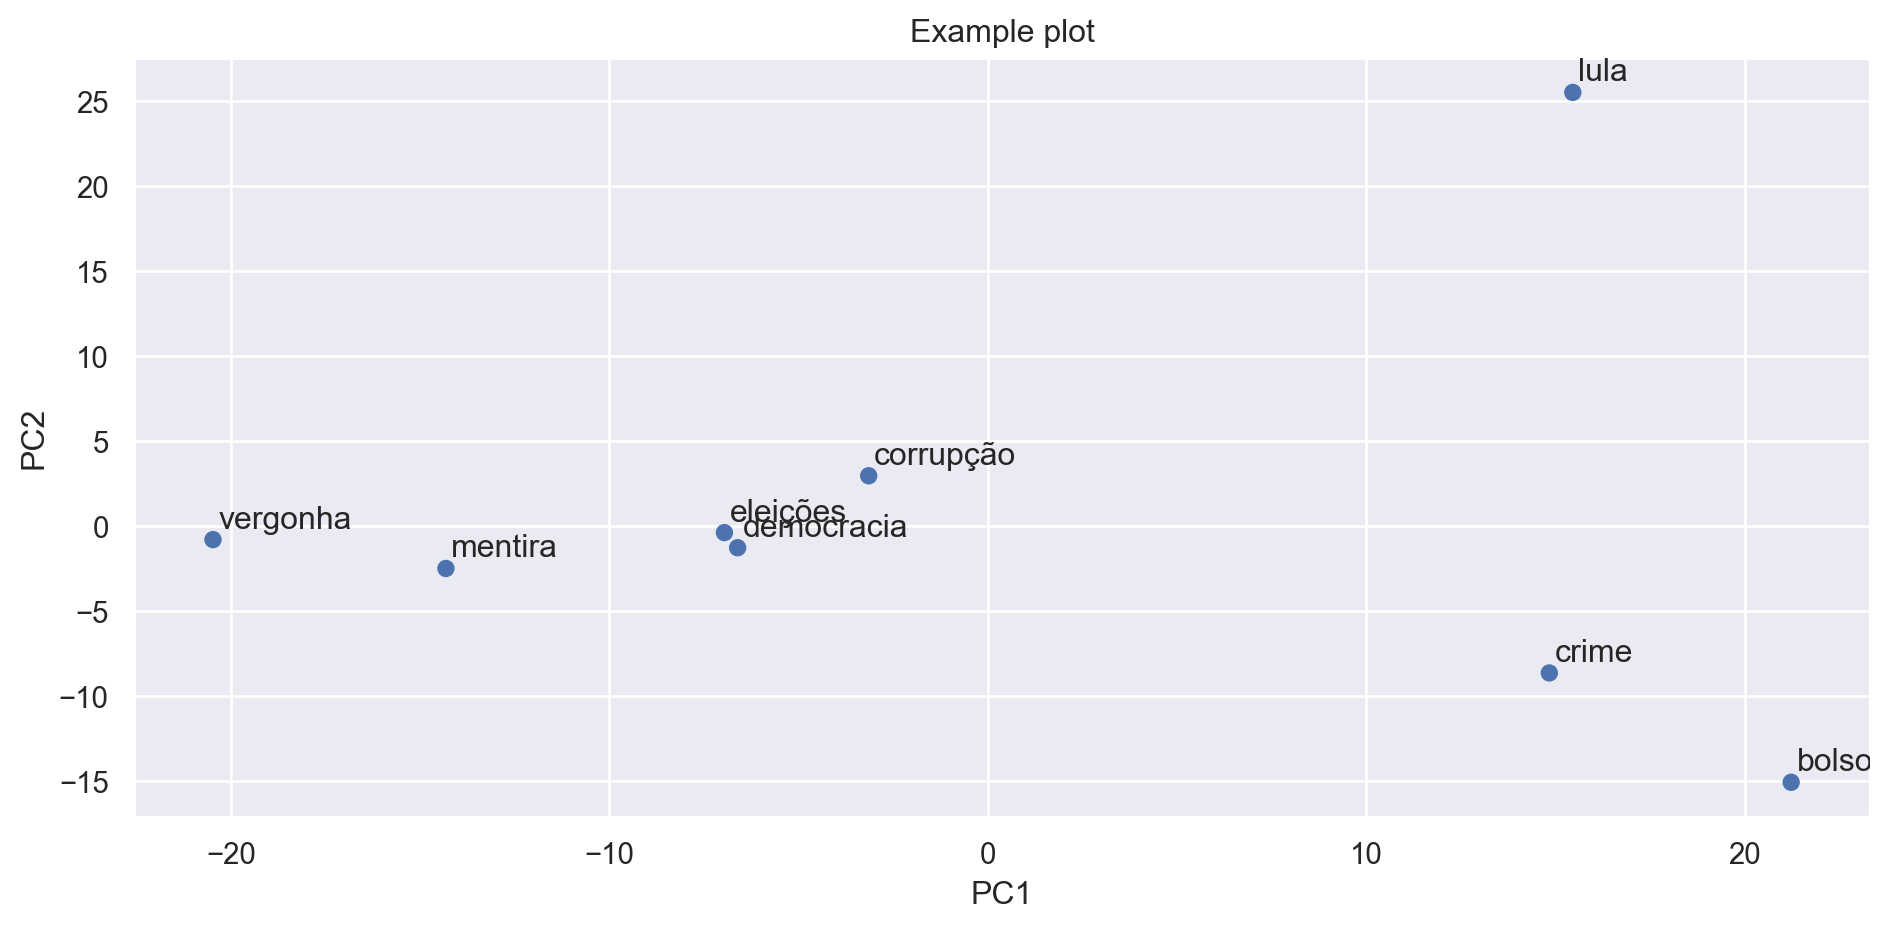

In [65]:
(
    sns.objects.Plot(
        data=word_vectors,
        x='x', 
        y='y', 
        text='words',
        # cmap='PRGn',
    )
    .add(so.Dot())
    .add(so.Text(halign="left", valign='bottom', offset=2))
    .label(title="Example plot", x="PC1", y="PC2")
    .layout(size=(10, 5))
)

In [66]:
for word in words:
    similar_vecs = w2v.wv.most_similar(word)
    similar_words = [vec[0] for vec in similar_vecs]
    print(f'{word}: {similar_words}\n')

lula: ['l', 'oleoleoleolá', 'corrupto', 'ladrão', 'ladrao', 'nunca', 'inocente', 'lulalarapioementiroso', 'celerado', 'venceu']

bolsonaro: ['pedófilo', 'pervertido', 'mentiu', 'crime', '', 'tremendo', 'super', 'minimo', 'live', 'bolsonaropedófilo']

eleições: ['gasolina', 'luiz', 'p/', 'lulaladrão', '°', 'bolsonaronoprimeiroturno22', 'preso', 'bolsonaroreeleito', 'facista', 'lulaladrao']

vergonha: ['passar', 'cara', 'pau', 'vc', 'ter', 'vcs', 'gente', 'ficar', 'boiada', 'pessoa']

crime: ['pervertido', 'pedófilo', 'mentiu', 'tremendo', 'roberto', 'jefferson', 'bolsonaro', 'jeferson', 'pintou', 'super']

mentira: ['esquerda', 'pessoa', 'boiada', 'muito', 'gente', 'querer', 'deus', 'de ele', 'rastro', '@rsallesmma']

democracia: ['alto', 'semana', 'social', 'grade', 'fugir', 'mar', 'nordestino', 'petrobrás', 'camisa', 'devolver']

corrupção: ['administrar', 'palavrão', 'expresidiário', 'uti', 'candidato', 'descondenado', 'amigo', 'mensalão', 'descondenar', 'idiotice']



# Unigram

In [ ]:
def nome_colunas(tokenizer, data_frame):
    # Extrai rotulos dos tokens
    vocabulario = {v: k for k, v in tokenizer.vocabulary_.items()}
    
    # Atribui rotulos dos tokens as colunas apropriadas
    data_frame.columns = data_frame.columns.map(vocabulario)
    
    return data_frame

In [ ]:
# Instanciando CountVectorizer
tokenizer_unigram_teste = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram_teste = tokenizer_unigram_teste.fit_transform(df_tweets['cleaned_tokens'])

# Criação do DF
bow_unigram_df_teste = pd.DataFrame(bow_unigram_teste.todense())

# Verificando 50 termos mais frequentes
nome_colunas(tokenizer_unigram_teste, bow_unigram_df_teste)

In [ ]:
# Unigrams para todos os tweets
bow_unigram_df_teste.sum().sort_values(ascending=False).head(30)

In [ ]:
# Unigrams para todos os tweets
df_unigram_teste = bow_unigram_df_teste.sum().sort_values(ascending=False).head(21).to_frame().reset_index()
df_unigram_teste.columns = ['termo', 'frequencia']
df_unigram_teste.head()

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(df_unigram_teste[1:], x = 'frequencia', y = 'termo', color = '#4682B4')
ax.set_title('20 Termos mais frequentes: Erika Hilton', fontsize=20, x=0.14, y=1.12, color="#696969")
ax.spines['bottom'].set_color('#696969')
ax.spines['left'].set_alpha(0)
ax.tick_params(axis='x', colors='#696969', labelsize = 10)
ax.tick_params(axis='y', colors='#696969', labelsize = 11)
ax.set_ylabel("", fontsize=12, loc="top", color="#696969")
ax.set_xlabel("Frequencia", fontsize=12, loc="left", color="#696969")
ax.yaxis.set_ticks_position('none')

subtitle_text = rf"${{Considerando\ todos\ os\ Tweets}}$ "
               
ax.text(-0.025, 1.06, subtitle_text, transform=ax.transAxes, fontsize=11, ha='center', color='#696969')

In [ ]:
#Teste com limpeza mais desenvolvida
#Instanciando Word2Vec para todos os tweets negativos
w2v_model_teste_ofensivos = Word2Vec(sentences = df_tweets_ofensivos['cleaned_content'],   # Passando listas de tokens tratados
                                     min_count=5,                                     # Mínimo de ocorrências para considerar a palavra
                                     vector_size=400,                                 # Dimensão final do embedding 
                                     window=5,                                        # Janela de contexto 
                                     seed = 42                                        # Definindo fator Pseudo aleatório
                                     )

In [ ]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" para todos os tweets
print(w2v_model_teste_ofensivos.wv.get_vector('@erikakhilton').shape)
w2v_model_teste_ofensivos.wv.get_vector('@erikakhilton')[:20]

In [ ]:
# Obtendo vetores das palavras
palavra_vec_teste_ofensivos = []
for i in palavras:
    palavra_vec_teste_ofensivos.append(w2v_model_teste_ofensivos.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x_teste_ofensivos = StandardScaler().fit_transform(palavra_vec_teste_ofensivos)

# Instanciando PCA
pca_teste_ofensivos = PCA(n_components=2)

# Fitando PCA
palavras_pca_teste_ofensivos = pca_teste_ofensivos.fit_transform(x_teste_ofensivos)

In [ ]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca_teste_ofensivos:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets: Erika Hilton', fontsize=20, x=0.1, y=1.2, color="#696969")
# ax.set_xlim(-20,50)
# ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ de\ todos\ os\ Tweets\ ofensivos\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.295, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

In [ ]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com os tweets ofensivos
w2v_model_teste_ofensivos.wv.most_similar('bolsonaro')

In [ ]:
# Visualizando vetores similares ao vetor "lula" modelo com os tweets ofensivos
w2v_model_teste_ofensivos.wv.most_similar('lula')

In [ ]:
# Visualizando vetores similares ao vetor "erika" modelo com todos os tweets
w2v_model_teste_ofensivos.wv.most_similar('erika')

In [ ]:
# Instanciando CountVectorizer
tokenizer_unigram_teste_ofensivos = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram_teste_ofensivos = tokenizer_unigram_teste_ofensivos.fit_transform(df_tweets_ofensivos['cleaned_tokens'])

# Criação do DF
bow_unigram_df_teste_ofensivos = pd.DataFrame(bow_unigram_teste_ofensivos.todense())

# Verificando 50 termos mais frequentes
nome_colunas(tokenizer_unigram_teste_ofensivos, bow_unigram_df_teste_ofensivos)

In [ ]:
# Unigrams para todos os tweets
bow_unigram_df_teste_ofensivos.sum().sort_values(ascending=False).head(30)

In [ ]:
# Unigrams para todos os tweets
df_unigram_teste_ofensivos = bow_unigram_df_teste_ofensivos.sum().sort_values(ascending=False).head(21).to_frame().reset_index()
df_unigram_teste_ofensivos.columns = ['termo', 'frequencia']
df_unigram_teste_ofensivos.head()

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(df_unigram_teste_ofensivos[1:], x = 'frequencia', y = 'termo', color = '#4682B4')
ax.set_title('20 Termos mais frequentes: Erika Hilton', fontsize=20, x=0.185, y=1.12, color="#696969")
ax.spines['bottom'].set_color('#696969')
ax.spines['left'].set_alpha(0)
ax.tick_params(axis='x', colors='#696969', labelsize = 10)
ax.tick_params(axis='y', colors='#696969', labelsize = 11)
ax.set_ylabel("", fontsize=12, loc="top", color="#696969")
ax.set_xlabel("Frequencia", fontsize=12, loc="left", color="#696969")
ax.yaxis.set_ticks_position('none')


subtitle_text = rf"${{Considerando\ Tweets\ ofensivos}}$ "
               
ax.text(0.025, 1.06, subtitle_text, transform=ax.transAxes, fontsize=11, ha='center', color='#696969')

In [ ]:
# Selecionando tweets negativos com score acima de 75%
tweets_ofensivos_acima_75 = df_tweets_ofensivos[df_tweets_ofensivos['class_score'] >= 0.75]

In [ ]:
#Teste com limpeza mais desenvolvida
#Instanciando Word2Vec para todos os tweets
w2v_model_teste_ofensivos_75 = Word2Vec(sentences = tweets_ofensivos_acima_75['cleaned_content'],   # Passando listas de tokens tratados
                                        min_count=5,                                     # Mínimo de ocorrências para considerar a palavra
                                        vector_size=400,                                 # Dimensão final do embedding 
                                        window=5,                                        # Janela de contexto 
                                        seed = 42                                        # Definindo fator Pseudo aleatório
                                        )

In [ ]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" para todos os tweets
print(w2v_model_teste_ofensivos_75.wv.get_vector('@erikakhilton').shape)
w2v_model_teste_ofensivos_75.wv.get_vector('@erikakhilton')[:20]

In [ ]:
# Obtendo vetores das palavras
palavra_vec_teste_ofensivos_75 = []
for i in palavras:
    palavra_vec_teste_ofensivos_75.append(w2v_model_teste_ofensivos_75.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x_teste_ofensivos_75 = StandardScaler().fit_transform(palavra_vec_teste_ofensivos_75)

# Instanciando PCA
pca_teste_ofensivos_75 = PCA(n_components=2)

# Fitando PCA
palavras_pca_teste_ofensivos_75 = pca_teste_ofensivos_75.fit_transform(x_teste_ofensivos_75)

In [ ]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca_teste_ofensivos_75:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets: Erika Hilton', fontsize=20, x=0.105, y=1.2, color="#696969")
# ax.set_xlim(-20,50)
# ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ de\ Tweets\ ofensivos\ com\ score\ acima\ de\ 0.75\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.39, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

In [ ]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com todos os tweets
w2v_model_teste_ofensivos_75.wv.most_similar('bolsonaro')

In [ ]:
# Visualizando vetores similares ao vetor "lula" modelo com todos os tweets
w2v_model_teste_ofensivos_75.wv.most_similar('lula')

In [ ]:
# Visualizando vetores similares ao vetor "erika" modelo com todos os tweets
w2v_model_teste_ofensivos_75.wv.most_similar('erika')

In [ ]:
# Instanciando CountVectorizer
tokenizer_unigram_teste_ofensivos_75 = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram_teste_ofensivos_75 = tokenizer_unigram_teste_ofensivos_75.fit_transform(tweets_ofensivos_acima_75['cleaned_tokens'])

# Criação do DF
bow_unigram_df_teste_ofensivos_75 = pd.DataFrame(bow_unigram_teste_ofensivos_75.todense())

# Verificando 50 termos mais frequentes
nome_colunas(tokenizer_unigram_teste_ofensivos_75, bow_unigram_df_teste_ofensivos_75)

In [ ]:
# Unigrams para todos os tweets
bow_unigram_df_teste_ofensivos_75.sum().sort_values(ascending=False).head(30)

In [ ]:
# Unigrams para todos os tweets
df_unigram_teste_ofensivos_75 = bow_unigram_df_teste_ofensivos_75.sum().sort_values(ascending=False).head(21).to_frame().reset_index()
df_unigram_teste_ofensivos_75.columns = ['termo', 'frequencia']
df_unigram_teste_ofensivos_75.head()

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(df_unigram_teste_ofensivos_75[1:], x = 'frequencia', y = 'termo', color = '#4682B4')
ax.set_title('20 Termos mais frequentes: Erika Hilton', fontsize=20, x=0.182, y=1.12, color="#696969")
ax.spines['bottom'].set_color('#696969')
ax.spines['left'].set_alpha(0)
ax.tick_params(axis='x', colors='#696969', labelsize = 10)
ax.tick_params(axis='y', colors='#696969', labelsize = 11)
ax.set_ylabel("", fontsize=12, loc="top", color="#696969")
ax.set_xlabel("Frequencia", fontsize=12, loc="left", color="#696969")
ax.yaxis.set_ticks_position('none')

subtitle_text = rf"${{Considerando\ Tweets\ ofensivos\ com\ score\ acima\ de\ 0.75}}$ "
               
ax.text(0.148, 1.06, subtitle_text, transform=ax.transAxes, fontsize=11, ha='center', color='#696969')

# Análise progrediu bem. Rodar Bi-grams e Tri-grams

# Abaixo codigos antigos

In [ ]:
# Selecionando pontuação e stopwords para limpeza
punct = ['.',',','!','?',':',';',')','(', '@']                               # Definindo lista de pontuações
stopwords_portugues = nltk.corpus.stopwords.words('portuguese') # Definindo lista de stopwords                                           # Adiciona tokens a lista 

In [ ]:
tokens_todos_tweets = [] # Cria lista para armazenar tokens de todos os tweets                                                
for doc in df_tweets['tweets']:
    token = (word_tokenize(doc))
    token_lwr = [x.lower() for x in token]                             # Tudo para minúsculo
    token_stp = [x for x in token_lwr if x not in stopwords_portugues] # Remove Stopwords
    token_pct = [x for x in token_stp if x not in punct]               # Remove pontuações
    tokens_todos_tweets.append(token_pct)

In [ ]:
# Cria coluna com tokens sem stopwords no dataframe
df_tweets['tokens_limpos'] = tokens_todos_tweets

In [ ]:
tokens_tweets_neg = [] # Cria lista para armazenar tokens de todos os tweets                                                
for doc in df_tweets_neg['tweets']:
    token = (word_tokenize(doc))
    token_lwr = [x.lower() for x in token]                             # Tudo para minúsculo
    token_stp = [x for x in token_lwr if x not in stopwords_portugues] # Remove Stopwords
    token_pct = [x for x in token_stp if x not in punct]               # Remove pontuações
    tokens_tweets_neg.append(token_pct)

In [ ]:
# Cria coluna com tokens sem stopwords no dataframe
df_tweets_neg['tokens_limpos'] = tokens_tweets_neg

In [ ]:
#Instanciando Word2Vec para todos os tweets
w2v_model = Word2Vec(sentences = df_tweets['tokens_limpos'],   # Passando listas de tokens tratados
                     min_count=5,                                     # Mínimo de ocorrências para considerar a palavra
                     vector_size=400,                                 # Dimensão final do embedding 
                     window=5,                                        # Janela de contexto 
                     seed = 42                                        # Definindo fator Pseudo aleatório
                     )

In [ ]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" para todos os tweets
print(w2v_model.wv.get_vector('erikakhilton').shape)
w2v_model.wv.get_vector('erikakhilton')[:20]

In [ ]:
#Instanciando Word2Vec para tweets negativos
w2v_model_neg = Word2Vec(sentences = tweets_negativos['tokens_limpos'],   # Passando listas de tokens tratados
                         min_count=5,                                     # Mínimo de ocorrências para considerar a palavra
                         vector_size=400,                                 # Dimensão final do embedding 
                         window=5,                                        # Janela de contexto 
                         seed = 42                                        # Definindo fator Pseudo aleatório
                        )

In [ ]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" para tweets negativos
print(w2v_model_neg.wv.get_vector('erikakhilton').shape)
w2v_model_neg.wv.get_vector('erikakhilton')[:20]

# PCA

Com a aplicação de um PCA (Principal Component Analysis) podemos reduzir a quantidade de dimensões de 400 para 2, dessa forma, podemos visualizar as palavras dentro de um espaço vetorial! 

Embora a interpretabilidade do eixo X e Y seja quase zero, é um ótimo exercício para gerar insights e se divertir um pouco!

In [ ]:
# Definindo palavras que serão visualizadas
palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']

In [ ]:
# Obtendo vetores das palavras
palavra_vec = []
for i in palavras:
    palavra_vec.append(w2v_model.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x = StandardScaler().fit_transform(palavra_vec)

# Instanciando PCA
pca = PCA(n_components=2)

# Fitando PCA
palavras_pca = pca.fit_transform(x)

In [ ]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets: Erika Hilton', fontsize=20, x=0.105, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ de\ todos\ os\ Tweets\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.24, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

In [ ]:
# Obtendo vetores das palavras
palavra_vec_neg = []
for i in palavras:
    palavra_vec_neg.append(w2v_model_neg.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x_neg = StandardScaler().fit_transform(palavra_vec_neg)

# Instanciando PCA
pca_neg = PCA(n_components=2)

# Fitando PCA
palavras_pca_neg = pca_neg.fit_transform(x_neg)

In [ ]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca_neg:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets Negativos: Erika Hilton', fontsize=20, x=0.207, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ dos\ Tweets\ Negativos\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.255, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

# Similaridade de vetores

In [ ]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com todos os tweets
w2v_model.wv.most_similar('bolsonaro')

In [ ]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com tweets negativos
w2v_model_neg.wv.most_similar('bolsonaro')

In [ ]:
# Visualizando vetores similares ao vetor "lula" modelo com todos os tweets
w2v_model.wv.most_similar('lula')

In [ ]:
# Visualizando vetores similares ao vetor "lula" modelo com tweets negativos
w2v_model_neg.wv.most_similar('lula')

In [ ]:
# Visualizando vetores similares ao vetor "erika" modelo com todos os tweets
w2v_model.wv.most_similar('erika', topn = 30)

In [ ]:
# Visualizando vetores similares ao vetor "erika" modelo com tweets negativos
w2v_model_neg.wv.most_similar('erikakhilton', topn = 30)

# Selecionando Scores Negativos > 75%

In [ ]:
tweets_neg_acima_75 = tweets_negativos[tweets_negativos['class_score'] >= 0.75]

In [ ]:
#Instanciando Word2Vec para tweets negativos acima de 75%
w2v_model_neg_75 = Word2Vec(sentences = tweets_neg_acima_75['tokens_limpos'],   # Passando listas de tokens tratados
                            min_count=5,                                        # Mínimo de ocorrências para considerar a palavra
                            vector_size=400,                                    # Dimensão final do embedding 
                            window=5,                                           # Janela de contexto 
                            seed = 42                                           # Definindo fator Pseudo aleatório
                        )

In [ ]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" modelo com tweets negativos acima de 75%
print(w2v_model_neg_75.wv.get_vector('erikakhilton').shape)
w2v_model_neg_75.wv.get_vector('erikakhilton')[:20]

# PCA

Com a aplicação de um PCA (Principal Component Analysis) podemos reduzir a quantidade de dimensões de 400 para 2, dessa forma, podemos visualizar as palavras dentro de um espaço vetorial! 

Embora a interpretabilidade do eixo X e Y seja quase zero, é um ótimo exercício para gerar insights e se divertir um pouco!

In [ ]:
# Definindo palavras que serão visualizadas
palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']
# palavras = ['lula','bolsonaro','democracia']

# palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']

# palavras1 = ['lula','bolsonaro','crime']

# palavras2 = ['lula','bolsonaro','mentira']

# palavras3 = ['lula','bolsonaro','democracia']

In [ ]:
# Obtendo vetores das palavras
palavra_vec_neg_75 = []
for i in palavras:
    palavra_vec_neg_75.append(w2v_model_neg_75.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x_neg_75 = StandardScaler().fit_transform(palavra_vec_neg_75)

# Instanciando PCA
pca_neg_75 = PCA(n_components=2)

# Fitando PCA
palavras_pca_neg_75 = pca_neg_75.fit_transform(x_neg_75)

In [ ]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca_neg_75:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets Negativos: Erika Hilton', fontsize=20, x=0.207, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ dos\ Tweets\ Negativos\ com\ score\ acima\ de\ 75\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.385, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

# Similaridade de vetores

In [ ]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com tweets negativos acima de 75%
w2v_model_neg_75.wv.most_similar('bolsonaro')

In [ ]:
# Visualizando vetores similares ao vetor "lula" modelo com tweets negativos acima de 75%
w2v_model_neg_75.wv.most_similar('lula')

In [ ]:
# Visualizando vetores similares ao vetor "erikakhilton" modelo com tweets negativos acima de 75%
w2v_model_neg_75.wv.most_similar('erikakhilton', topn = 30)

In [ ]:
def limpar_texto(texto):
    # Converte para caixa baixa
    texto = texto.lower()
    
    # Tokenização
    doc = nlp(texto)
    
    # Exclui STOPWORDS, pontuação e números
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    
    # Agrupando review
    texto_limpo = " ".join(tokens)
    
    return texto_limpo


In [ ]:
# Apply the cleaning function to the 'text_column' in the DataFrame
df_tweets['texto_limpo'] = df_tweets['tweets'].apply(limpar_texto)

In [ ]:
# Apply the cleaning function to the 'text_column' in the DataFrame
tweets_neg_acima_75['texto_limpo'] = tweets_neg_acima_75['tweets'].apply(limpar_texto)

In [ ]:
def nome_colunas(tokenizer, data_frame):
    # Extrai rotulos dos tokens
    vocabulario = {v: k for k, v in tokenizer.vocabulary_.items()}
    
    # Atribui rotulos dos tokens as colunas apropriadas
    data_frame.columns = data_frame.columns.map(vocabulario)
    
    return data_frame

In [ ]:
# Instanciando CountVectorizer
tokenizer_unigram = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram = tokenizer_unigram.fit_transform(df_tweets['tokens_texto'])

# Criação do DF
bow_unigram_df = pd.DataFrame(bow_unigram.todense())

# Verificando 50 termos mais frequentes
nome_colunas(tokenizer_unigram, bow_unigram_df)

In [ ]:
# Unigrams para todos os tweets
bow_unigram_df.sum().sort_values(ascending=False).head(30)

In [ ]:
# Instanciando CountVectorizer
tokenizer_unigram_neg_75 = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram_neg_75 = tokenizer_unigram_neg_75.fit_transform(tweets_neg_acima_75['tokens_texto'])

# Criação do DF
bow_unigram_df_neg_75 = pd.DataFrame(bow_unigram_neg_75.todense())

# Verificando 50 termos mais frequentes
nome_colunas(tokenizer_unigram_neg_75, bow_unigram_df_neg_75)

In [ ]:
# Unigrams para tweets com score acima de 75%
bow_unigram_df_neg_75.sum().sort_values(ascending=False).head(30)

# Avaliação de contexto entre todos tweets x tweets negativos acaba na celula acima

In [ ]:
# Instanciando CountVectorizer
tokenizer_bigram = CountVectorizer(ngram_range = (2,2))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_bigram = tokenizer_bigram.fit_transform(tweets_neg_acima_75['tokens_texto'])

# Criação do DF
bow_bigram_df = pd.DataFrame(bow_bigram.todense())

# Aplicando função
nome_colunas(tokenizer_bigram, bow_bigram_df)

In [ ]:
# Verificando 50 termos mais frequentes
bow_bigram_df.sum().sort_values(ascending=False).head(50)

In [ ]:
# Instanciando CountVectorizer
tokenizer_trigram = CountVectorizer(ngram_range=(3,3))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_trigram = tokenizer_trigram.fit_transform(tweets_neg_acima_75['tokens_texto'])

# Criando DF
bow_trigram_df = pd.DataFrame(bow_trigram.todense())

# Aplicando função
nome_colunas(tokenizer_trigram, bow_trigram_df)

In [ ]:
# Verificando 50 termos mais frequentes
bow_trigram_df.sum().sort_values(ascending=False).head(50)

In [ ]:
# Definindo palavras que serão visualizadas
palavras = ['erikakhilton','bolsonaro','terrorista']

# palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']

palavras1 = ['lula','bolsonaro','crime']

palavras2 = ['lula','bolsonaro','mentira']

palavras3 = ['lula','bolsonaro','democracia']

In [ ]:
# Obtendo vetores das palavras
palavra_vec = []
for i in palavras:
    palavra_vec.append(w2v_model.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x = StandardScaler().fit_transform(palavra_vec)

# Instanciando PCA
pca = PCA(n_components=2)

# Fitando PCA
palavras_pca = pca.fit_transform(x)

In [ ]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets Negativos: Erika Hilton', fontsize=20, x=0.207, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ para\ palavras\ com\ maior\ similaridade\ ao\ nome\ Erika}$"

# Add the subtitle with formatted text
ax.text(0.255, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')